In [1]:
import os
import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt
import pickle
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
nodes = pd.read_csv('../data/nodes_condensed.csv')
edges = pd.read_csv('../data/edges_condensed.csv', converters={'pmids':eval})

# remove : character from column names to make them queryable
nodes = gt.remove_colons(nodes)
edges = gt.remove_colons(edges)

In [3]:
comps = (nodes['LABEL'] == 'Chemicals & Drugs').sum() 
diseases = (nodes['LABEL'] == 'Disorders').sum()

print('{:,} Compounds x {:,} Diseases = {:,} C-D pairs'.format(comps, diseases, comps*diseases))

98,547 Compounds x 43,228 Diseases = 4,259,989,716 C-D pairs


In [4]:
nodes.head(2)

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors


In [5]:
edges.head(2)

,START_ID,END_ID,TYPE,pmids,n_pmids
0,C1273870,C0282623,ADMINISTERED_TO_ABatAB,{17170614},1
1,C1273870,C1138603,ADMINISTERED_TO_ABatCI,"{15842188, 12943031}",2


In [6]:
counts = edges["TYPE"].value_counts()
counts

ASSOCIATED_WITH_CDawCD           1415748
LOCATION_OF_AloCD                1048781
INTERACTS_WITH_CDiwG              732705
ASSOCIATED_WITH_DOawDO            712286
TREATS_CDtDO                      634946
AFFECTS_DOafLB                    627265
ASSOCIATED_WITH_CDawDO            613957
LOCATION_OF_AloG                  566189
LOCATION_OF_AloDO                 563006
PRODUCES_LBpdCD                   525948
STIMULATES_CDst>CD                512811
TREATS_PRtDO                      446603
INHIBITS_CDinCD                   439092
AUGMENTS_CDagDO                   414322
STIMULATES_CDstG                  386302
AFFECTS_CDafPS                    367386
AFFECTS_CDafA                     336482
ASSOCIATED_WITH_GawDO             327017
AUGMENTS_DOag>DO                  303738
USES_PRuCD                        293601
LOCATION_OF_AloA                  274594
PART_OF_GpoLB                     273154
AFFECTS_GafPS                     262443
INTERACTS_WITH_GiwG               248477
INHIBITS_CDinG  

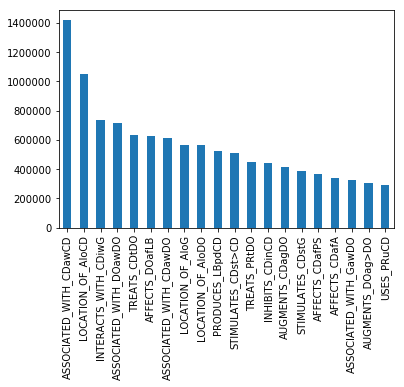

In [7]:
counts[:20].plot(kind='bar');

# Filter out the lower count edge types

In [8]:
'{:,}'.format(edges.shape[0])

'17,730,091'

In [9]:
cutoff = .001

print("Number of edge types with this cutoff: {}".format((counts > cutoff*len(edges)).sum()))
print("Number of edges that remain with this cutoff: {:,}".format(counts[counts > cutoff*len(edges)].sum()))

Number of edge types with this cutoff: 75
Number of edges that remain with this cutoff: 16,693,497


In [10]:
ok_edges = list(counts[counts > cutoff*len(edges)].index)

In [11]:
result = edges.query('TYPE in @ok_edges')

In [12]:
'{:,}'.format(result.shape[0])

'16,693,497'

# Some quick validation that all ids are the same between nodes and edges

In [13]:
edge_ids = set(result['START_ID'].unique()).union(set(result['END_ID'].unique()))

In [14]:
node_ids = set(nodes['ID'].unique())

In [15]:
not_in_edges = node_ids - edge_ids

In [16]:
not_in_edges = list(not_in_edges)

In [17]:
idx = nodes.query('ID in @not_in_edges').index
nodes.loc[idx]

,ID,name,LABEL
0,C0038195,State Medicine,Activities & Behaviors
1,C0233512,Normal behavior,Activities & Behaviors
2,C0680431,Apartheid,Activities & Behaviors
3,C0037400,Social Change,Activities & Behaviors
4,C0078912,Aikido,Activities & Behaviors
5,C0680718,arraignment,Activities & Behaviors
6,C0282352,National Security,Activities & Behaviors
7,C0024818,Marital Relationship,Activities & Behaviors
11,C0871808,Management Methods,Activities & Behaviors
12,C1521911,NCI Unconventional Innovations Program,Activities & Behaviors


In [18]:
nodes = nodes.drop(idx)

In [19]:
len(nodes)

258184

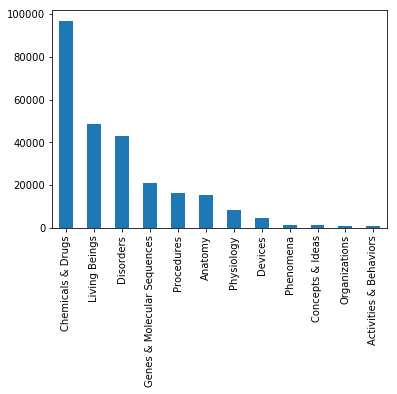

In [20]:
nodes['LABEL'].value_counts().plot(kind='bar');

# Do some EDA

In [21]:
combo = gt.combine_nodes_and_edges(gt.add_colons(nodes), gt.add_colons(result[['START_ID', 'END_ID', 'TYPE', 'n_pmids']]))
combo = gt.remove_colons(combo)

In [22]:
combo.head(2)

,START_ID,END_ID,TYPE,n_pmids,start_name,end_name,start_label,end_label
1906,C0879427,C0030705,ADMINISTERED_TO_CDatLB,54,panitumumab,Patients,Chemicals & Drugs,Living Beings
1907,C0209263,C0030705,ADMINISTERED_TO_CDatLB,3,piroxicam-beta-cyclodextrin,Patients,Chemicals & Drugs,Living Beings


In [23]:
max_edge = combo["n_pmids"].max()
combo.query('n_pmids == @max_edge')

,START_ID,END_ID,TYPE,n_pmids,start_name,end_name,start_label,end_label
17017126,C0087111,C0030705,TREATS_PRtLB,136116,Therapeutic procedure,Patients,Procedures,Living Beings


In [24]:
frame = pd.DataFrame()
for i in range(10):

    to_plot = combo.query('n_pmids > @i')['TYPE'].value_counts()
    to_plot = to_plot / to_plot.sum()
    frame[i+1] = to_plot

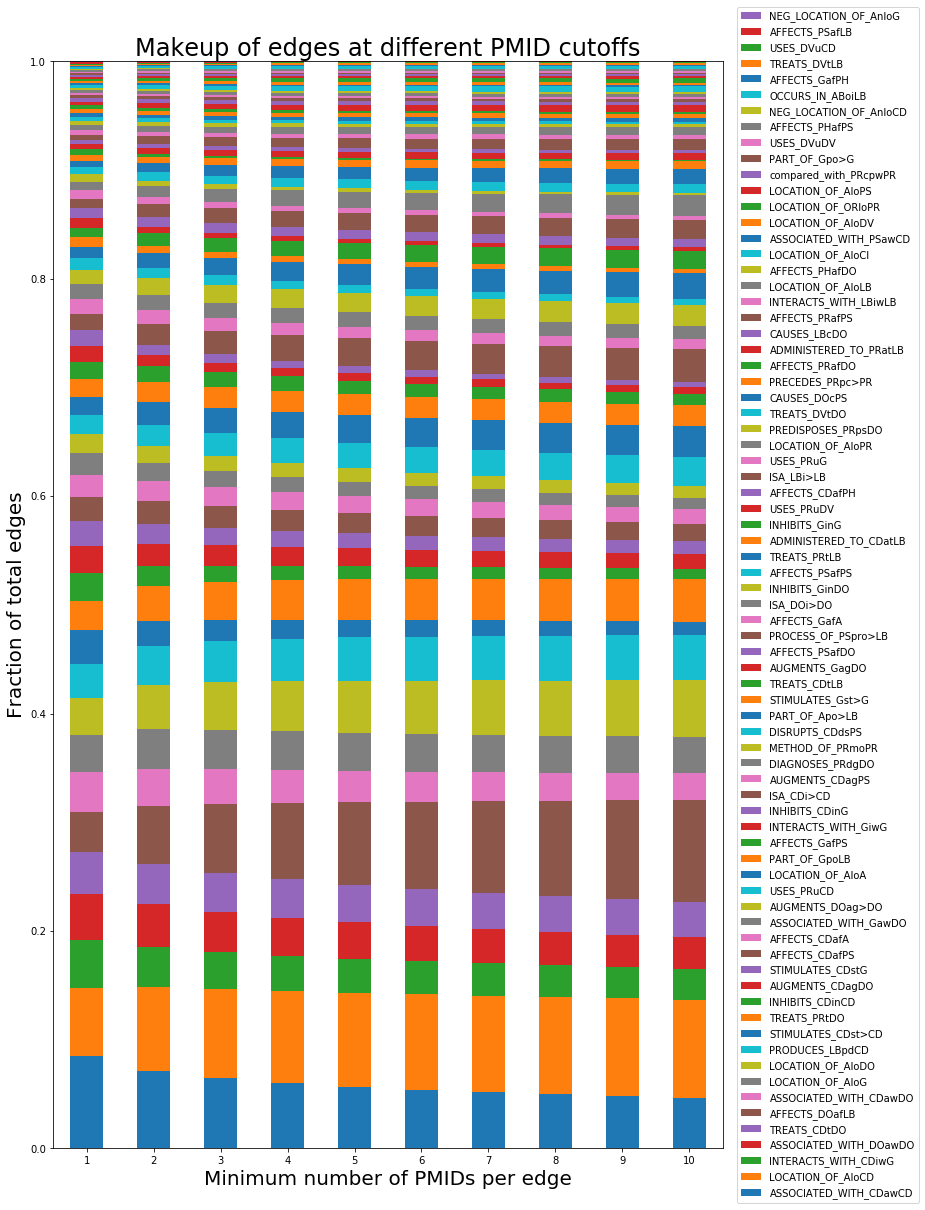

In [25]:
fig = frame.T.plot.bar(stacked=True, figsize=(12, 20))
handels, labels = fig.axes.get_legend_handles_labels()
plt.legend(handels[::-1], labels[::-1], loc=7, bbox_to_anchor=(1.3, 0.5))
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.title('Makeup of edges at different PMID cutoffs', size=24)
plt.xlabel('Minimum number of PMIDs per edge', size=20)
plt.ylabel('Fraction of total edges', size = 20);

In [26]:
combo.sort_values('n_pmids', ascending=False)[['n_pmids', 'start_name', 'TYPE', 'end_name']].iloc[:60]

,n_pmids,start_name,TYPE,end_name
17017126,136116,Therapeutic procedure,TREATS_PRtLB,Patients
1230175,95235,Disease,AFFECTS_DOafLB,Patients
16943513,89993,Operative Surgical Procedures,TREATS_PRtLB,Patients
1020128,62830,Symptoms,AFFECTS_DOafLB,Patients
1594792,58758,Malignant Neoplasms,AFFECTS_DOafLB,Patients
1317056,55820,Complication,AFFECTS_DOafLB,Patients
1074147,52423,Diabetic,AFFECTS_DOafLB,Patients
135164,49154,Therapeutic procedure,ADMINISTERED_TO_PRatLB,Patients
1250777,48097,Neoplasm,AFFECTS_DOafLB,Patients
13224757,45915,Liver,PART_OF_Apo>LB,Rattus norvegicus


In [27]:
combo.query('START_ID == END_ID')['TYPE'].value_counts()

INTERACTS_WITH_GiwG      3557
STIMULATES_Gst>G         2729
INHIBITS_GinG            2174
compared_with_PRcpwPR    1774
PART_OF_Gpo>G             939
Name: TYPE, dtype: int64

There are some instances of self-referrential edges.  These should be removed as they are not vaild in DWPC feature extraction.

In [28]:
result = gt.remove_colons(result)
idx = result.query('START_ID == END_ID').index
result = result.drop(idx)

In [29]:
node_degrees = pd.concat([combo['start_name'], combo['end_name']]).value_counts()

In [30]:
node_degrees[:60]

Patients                         98820
Disease                          68988
Therapeutic procedure            66369
Cells                            64386
Proteins                         51775
Pharmaceutical Preparations      50470
Rattus norvegicus                49111
Mus                              43511
Human                            42948
Child                            40553
Neoplasm                         39410
Genes                            39045
Woman                            34747
Malignant Neoplasms              34597
Growth                           34210
Body tissue                      32078
DNA                              30594
Individual                       30461
Antibodies                       30201
Brain                            29076
Operative Surgical Procedures    28514
Adult                            27427
Liver                            27413
Enzymes                          27071
Symptoms                         26930
Syndrome                 

In [31]:
#These are from the 100 most common nodes, removing things that are too general to be usefl

too_general = ['Patients', 'Cells', 'Disease', 'Therapeutic procedure', 'Proteins', 'Pharmaceutical Preparations',
 'Mus', 'Human', 'Child', 'Genes', 'Woman', 'Body tissue', 'Malignant Neoplasms', 'Growth', 'Individual', 'Antibodies',
 'Operative Surgical Procedures', 'Adult', 'Enzymes', 'Symptoms', 'Syndrome', 'Animals', 'Cell Line', 'Injury', 'Complication',
 'House mice', 'Functional disorder', 'Infant', 'Family', 'Persons', 'Male population group', 'Monoclonal Antibodies',
 'Toxic effect', 'Infection', 'DNA Sequence', 'Control Groups', 'Injection procedure', 'Ions', 'Transcription, Genetic',
 'Organ', 'TRANSCRIPTION FACTOR', 'cohort']

In [32]:
idx = nodes.query('name in @too_general').index
nodes = nodes.drop(idx).reset_index(drop=True)

In [33]:
node_ids = nodes['ID'].unique()

In [34]:
result = result.query('START_ID in @node_ids and END_ID in @node_ids')

In [35]:
'{:,} Edges remain'.format(len(result))

'15,379,509 Edges remain'

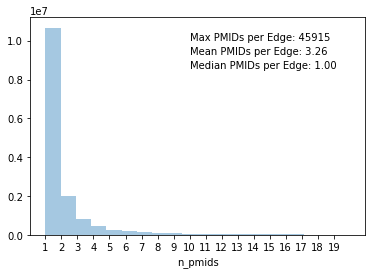

In [43]:
sns.distplot(result[result['n_pmids'] < 21]['n_pmids'], bins=20, kde=False)
plt.xticks(np.arange(1, 20, 1))
plt.text(10, 1.0e7, 'Max PMIDs per Edge: {}'.format(result['n_pmids'].max()))
plt.text(10, 0.93e7, 'Mean PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].mean()))
plt.text(10, 0.86e7, 'Median PMIDs per Edge: {:1.2f}'.format(result['n_pmids'].median()));

In [38]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, (result['n_pmids'] >= i).sum()))

Edges with at least 1 unique PMIDs: 15,379,509
Edges with at least 2 unique PMIDs: 4,715,034
Edges with at least 3 unique PMIDs: 2,694,288
Edges with at least 4 unique PMIDs: 1,871,744
Edges with at least 5 unique PMIDs: 1,427,638
Edges with at least 6 unique PMIDs: 1,149,999
Edges with at least 7 unique PMIDs: 960,138
Edges with at least 8 unique PMIDs: 822,057
Edges with at least 9 unique PMIDs: 717,098
Edges with at least 10 unique PMIDs: 634,812


In [44]:
result = gt.add_colons(result)
nodes = gt.add_colons(nodes)

result.to_csv('../data/edges_condensed_filtered_001.csv', index=False)
nodes.to_csv('../data/nodes_condensed_filtered_001.csv', index=False)